In [1]:
import sys

sys.path.append("..")

from src.flex_bert import create_flex_bert_mlm

/workspace/miniconda3/envs/bert24/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/miniconda3/envs/bert24/lib/python3.11/site-packages/flash_attn/ops/triton/layer_norm.py:958: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/workspace/miniconda3/envs/bert24/lib/python3.11/site-packages/flash_attn/ops/triton/layer_norm.py:1017: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


In [2]:
from omegaconf import OmegaConf

cfg = OmegaConf.load("../yamls/main/flex-bert-rope-parallel-firstprenorm-softpick.yaml")

model = create_flex_bert_mlm(
    model_config=cfg.model.model_config, 
)
import torch

x = torch.load("../experiments/flex-bert-rope-parallel-firstprenorm-softpick/ckpt/latest-rank0.pt")

model.load_state_dict(x["state"]["model"])

model = model.to("cuda")

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

model

/workspace/miniconda3/envs/bert24/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_1138/4099114977.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be 

EfficientHuggingFaceModel(
  (model): FlexBertForMaskedLM(
    (bert): FlexBertModel(
      (embeddings): FlexBertSansPositionEmbeddings(
        (tok_embeddings): Embedding(30528, 768, padding_idx=0)
        (norm): RMSNorm()
        (drop): Identity()
      )
      (encoder): FlexBertUnpadEncoder(
        (layers): ModuleList(
          (0): FlexBertUnpadParallelPreNormLayer(
            (Wqkvff): Linear(in_features=768, out_features=8448, bias=False)
            (norm): Identity()
            (attn): FlexBertUnpadRopeParallelSoftpickAttention(
              num_attention_heads=12, attn_head_size=64, sliding_window=False, use_fa2=True, deterministic_fa2=False
              (Wo): Linear(in_features=768, out_features=768, bias=False)
              (out_drop): Identity()
              (rotary_emb): UnpaddedRotaryEmbedding(dim=64, base=10000.0, scale_base=None)
            )
            (mlp): FlexBertParallelGLU(
              (act): GELU(approximate='none')
              (drop): Identi

In [ ]:
text = "The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism."
input_ids = tokenizer(text, return_tensors="pt").to("cuda")
tokens = tokenizer.convert_ids_to_tokens(input_ids["input_ids"][0].tolist())

for layer_module in model.model.bert.encoder.layers:
    if hasattr(layer_module.attn, '_captured_attention_probabilities'):
        layer_module.attn._captured_attention_probabilities = None

with torch.no_grad():
    outputs = model(input_ids)

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

def plot_all_layer_attentions(
    all_layers_attention_data,  # List of tensors (one per layer) or None
    tokens,                     # List of token strings for axis labels
    batch_idx_to_plot=0,        # Which item in the batch to plot
    head_to_display=0,          # Specific head index to display for all layers.
                                # Set to 'avg' to average across heads.
    num_cols=4,                 # Number of columns in the subplot grid
    figure_figsize=(20, 20),    # Overall size of the giant plot
    save_path=None              # Optional path to save the figure
):
    """
    Creates a grid plot of attention maps for all layers.

    Args:
        all_layers_attention_data (list): A list where each element is either:
            - a torch.Tensor of shape (batch, heads, seq_len, seq_len)
            - None (if attention for that layer was not captured or applicable)
        tokens (list): List of token strings for plot labels.
        batch_idx_to_plot (int): Index of the batch item to visualize.
        head_to_display (int or str):
            - If int: The specific head index to display for all layers.
            - If 'avg': Average attention across all heads for each layer.
        num_cols (int): Number of columns for the subplot grid.
        figure_figsize (tuple): Size of the matplotlib figure.
        save_path (str, optional): If provided, saves the figure to this path.
    """
    num_layers = len(all_layers_attention_data)
    if num_layers == 0:
        print("No attention data provided.")
        return

    # Determine grid size
    if num_layers < num_cols:
        num_cols = num_layers
    num_rows = math.ceil(num_layers / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=figure_figsize)
    axes = axes.flatten()  # Flatten to 1D array for easy iteration

    plot_count = 0
    for layer_idx in range(num_layers):
        layer_attention_probs = all_layers_attention_data[layer_idx]
        ax = axes[plot_count] # Get the current subplot axis

        if layer_attention_probs is None:
            ax.text(0.5, 0.5, f"Layer {layer_idx}\nNo Data", ha='center', va='center', fontsize=10, color='grey')
            ax.set_xticks([])
            ax.set_yticks([])
            plot_count += 1
            continue

        # Ensure batch_idx is valid
        if batch_idx_to_plot >= layer_attention_probs.shape[0]:
            error_msg = f"Layer {layer_idx}\nBatch index {batch_idx_to_plot} out of range."
            ax.text(0.5, 0.5, error_msg, ha='center', va='center', fontsize=9, color='red')
            print(error_msg + f" Tensor shape: {layer_attention_probs.shape}")
            ax.set_xticks([])
            ax.set_yticks([])
            plot_count += 1
            continue
            
        num_heads_in_tensor = layer_attention_probs.shape[1]
        seq_len = layer_attention_probs.shape[2] # Assuming seq_len_query == seq_len_key

        title_suffix = ""
        if isinstance(head_to_display, int):
            if head_to_display >= num_heads_in_tensor:
                error_msg = f"Layer {layer_idx}\nHead {head_to_display} out of range (0-{num_heads_in_tensor-1})."
                ax.text(0.5, 0.5, error_msg, ha='center', va='center', fontsize=9, color='red')
                print(error_msg)
                ax.set_xticks([])
                ax.set_yticks([])
                plot_count += 1
                continue
            
            # Select specific head
            attention_map = layer_attention_probs[batch_idx_to_plot, head_to_display, :, :].cpu().numpy()
            title_suffix = f"Head {head_to_display}"
        elif str(head_to_display).lower() == 'avg':
            # Average across heads
            attention_map = layer_attention_probs[batch_idx_to_plot, :, :, :].mean(dim=0).cpu().numpy()
            title_suffix = "Avg. Heads"
        else:
            error_msg = f"Layer {layer_idx}\nInvalid 'head_to_display' value: {head_to_display}.\nUse int or 'avg'."
            ax.text(0.5, 0.5, error_msg, ha='center', va='center', fontsize=9, color='red')
            print(error_msg)
            ax.set_xticks([])
            ax.set_yticks([])
            plot_count += 1
            continue

        # Prepare tokens for labels (ensure length matches)
        plot_tokens = tokens[:seq_len]

        sns.heatmap(attention_map, xticklabels=plot_tokens, yticklabels=plot_tokens, cmap="viridis", ax=ax, cbar=False) # cbar=False for cleaner grid
        ax.set_title(f"Layer {layer_idx}\n{title_suffix}", fontsize=10)
        ax.tick_params(axis='x', labelsize=8, labelrotation=45)
        ax.tick_params(axis='y', labelsize=8, labelrotation=0)
        plot_count += 1

    # Hide any unused subplots
    for i in range(plot_count, len(axes)):
        fig.delaxes(axes[i])

    fig.suptitle(f"Attention Maps (Batch {batch_idx_to_plot})", fontsize=16, y=0.99 if num_rows > 1 else 1.03) # Adjust y for suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.96 if num_rows > 1 else 0.9]) # Adjust rect to make space for suptitle
    
    if save_path:
        plt.savefig(save_path)
        print(f"Saved giant plot to {save_path}")
    else:
        plt.show()

In [7]:
attention_data_for_plotting = []
if hasattr(model, 'model') and hasattr(model.model, 'bert') and \
   hasattr(model.model.bert, 'encoder') and hasattr(model.model.bert.encoder, 'layers'):
    for layer_module in model.model.bert.encoder.layers:
        if hasattr(layer_module, 'attn') and \
           hasattr(layer_module.attn, '_captured_attention_probabilities'):
            attention_data_for_plotting.append(layer_module.attn._captured_attention_probabilities)
        else:
            # Append None if probabilities are not found for this layer,
            # so the plotting function knows to skip or mark it.
            attention_data_for_plotting.append(None)
            print(f"Warning: Could not find '_captured_attention_probabilities' for an attention module in a layer.")
else:
    print("Error: Could not access model.model.bert.encoder.layers. Check model structure.")

In [8]:
input_ids["input_ids"].shape

torch.Size([1, 45])

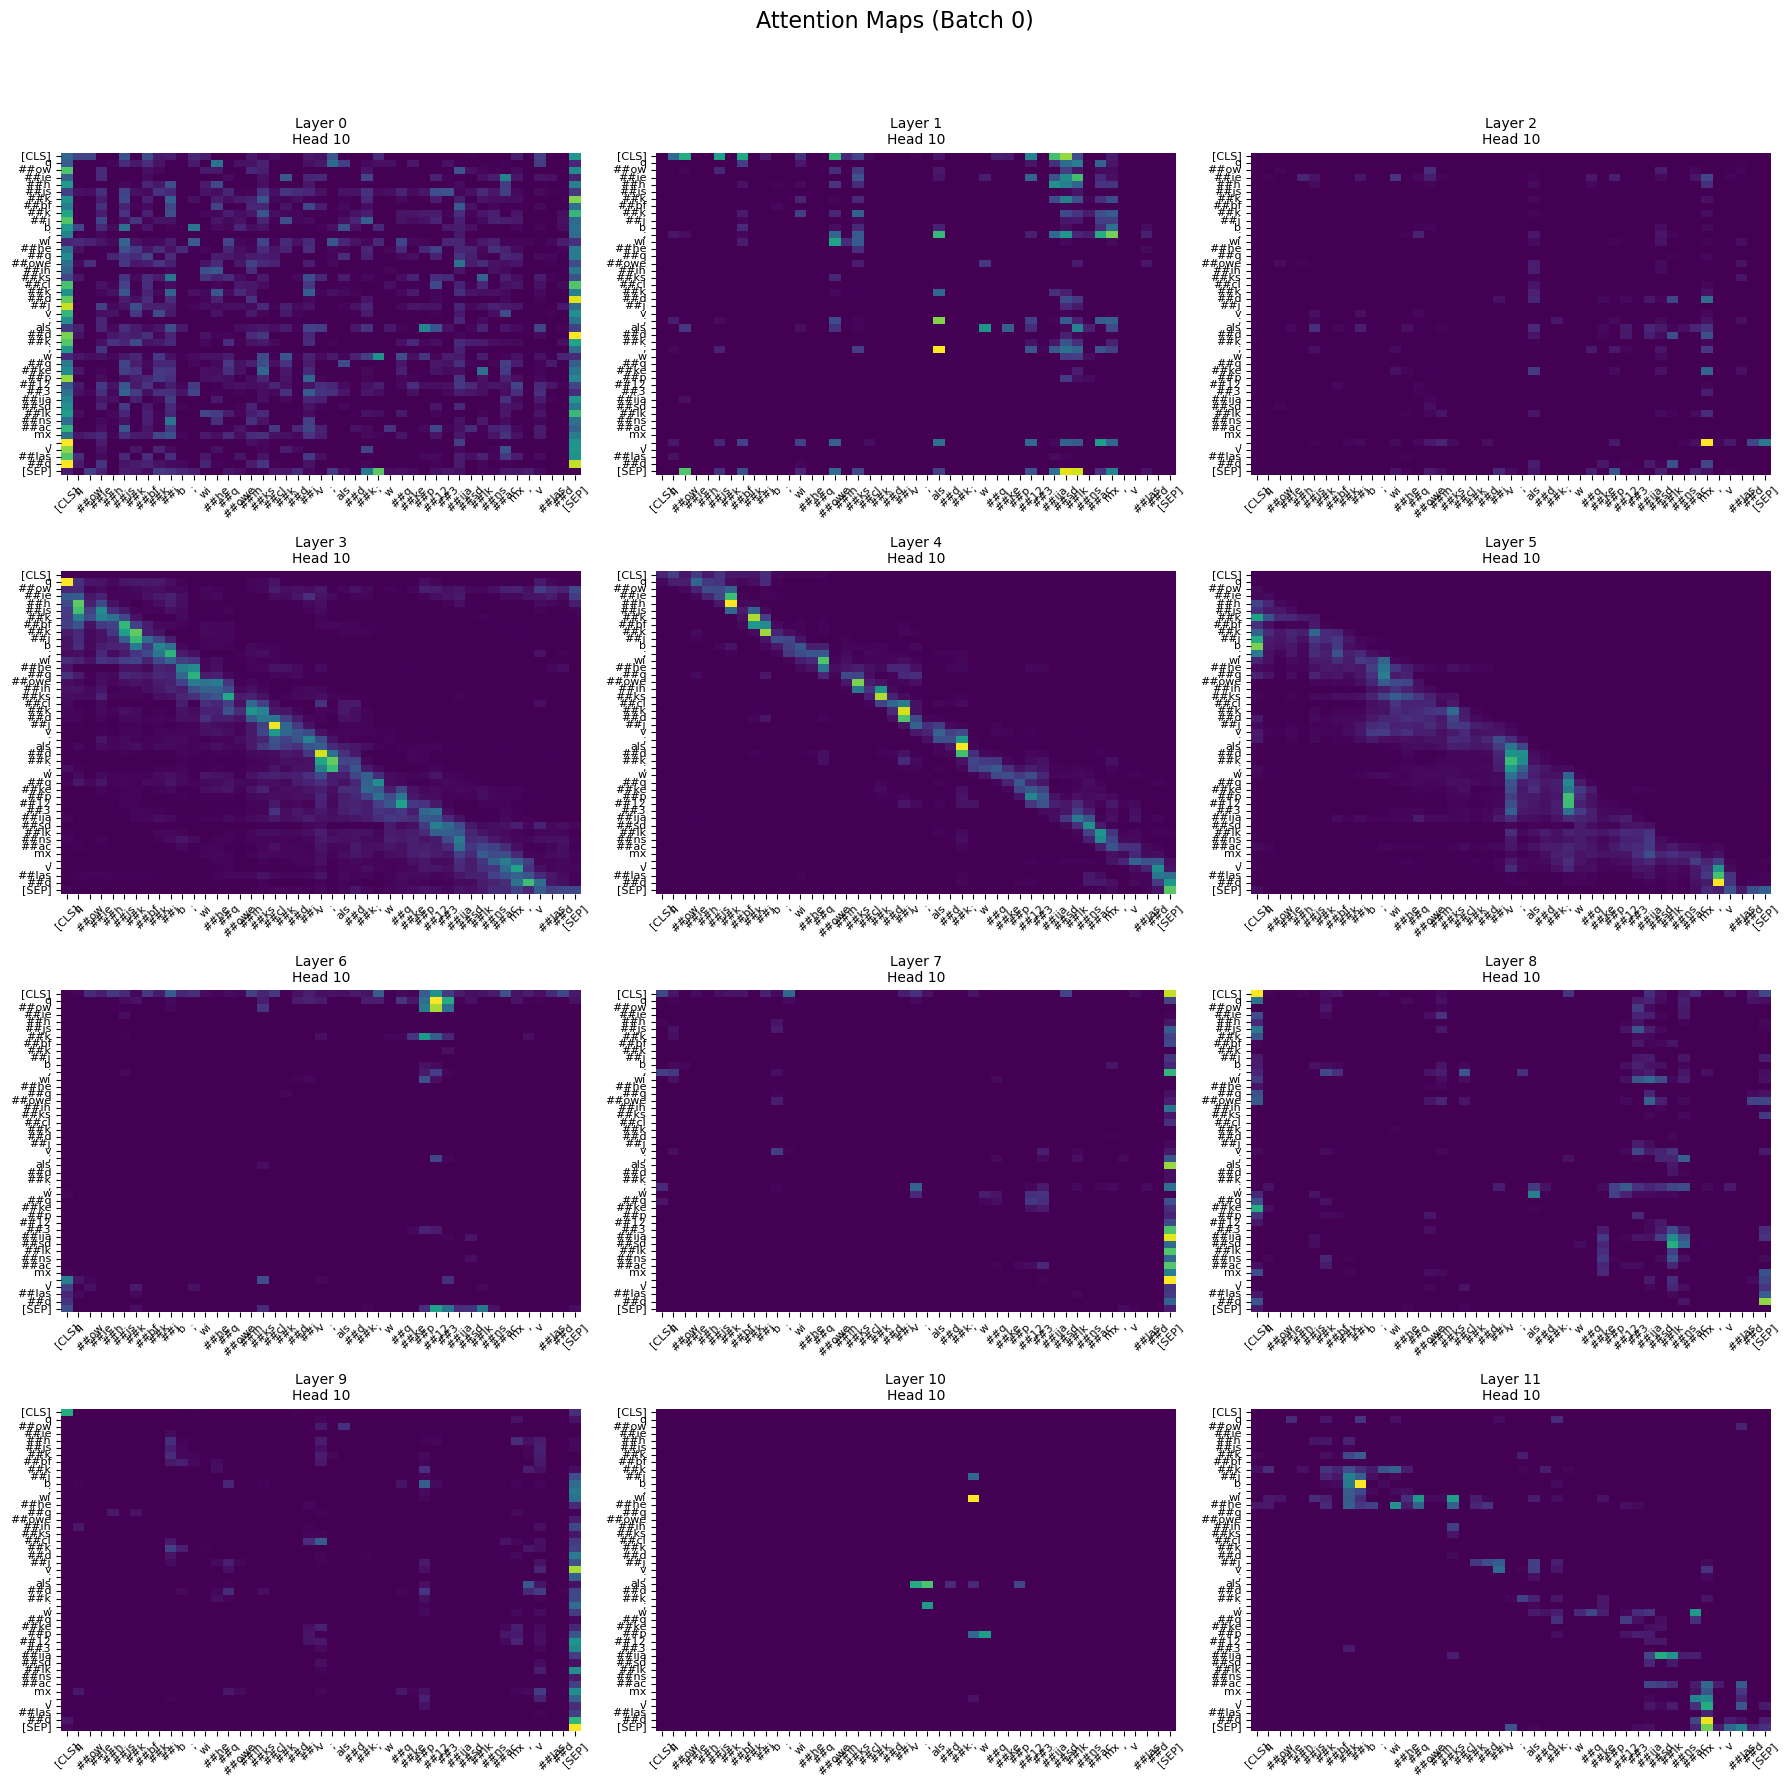

In [9]:
plot_all_layer_attentions(
    attention_data_for_plotting,
    tokens=tokens, # Your list of token strings
    batch_idx_to_plot=0,
    head_to_display=10,
    num_cols=3, # Adjust as needed
    figure_figsize=(18, 18), # Adjust as needed
)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import torch # Assuming your tensors are PyTorch tensors

def plot_all_heads_for_layer(
    layer_attention_probs,    # Single tensor for one layer: (batch, heads, seq_len, seq_len)
    tokens,                   # List of token strings for axis labels
    layer_number_for_title,   # Integer, e.g., 0 for the first layer, for the plot title
    batch_idx_to_plot=0,      # Which item in the batch to plot
    num_cols=4,               # Number of columns in the subplot grid for heads
    figure_figsize_scale=(5, 4), # Approx (width, height) per head subplot
    save_path=None            # Optional path to save the figure
):
    """
    Creates a grid plot of attention maps for all heads in a single specified layer.

    Args:
        layer_attention_probs (torch.Tensor): The attention tensor for a specific layer,
            expected shape (batch_size, num_heads, seq_len, seq_len).
        tokens (list): List of token strings for plot labels.
        layer_number_for_title (int): The layer index (0-based) for titling the plot.
        batch_idx_to_plot (int): Index of the batch item to visualize.
        num_cols (int): Number of columns for the subplot grid.
        figure_figsize_scale (tuple): Multiplier for figure size based on grid.
                                     (width_per_col, height_per_row).
        save_path (str, optional): If provided, saves the figure to this path.
    """
    if layer_attention_probs is None:
        print(f"No attention data provided for layer {layer_number_for_title}.")
        return

    # Validate tensor dimensions
    if not isinstance(layer_attention_probs, torch.Tensor) or layer_attention_probs.ndim != 4:
        print(f"Error: layer_attention_probs for layer {layer_number_for_title} is not a 4D tensor. "
              f"Received type: {type(layer_attention_probs)}, ndim: {layer_attention_probs.ndim if hasattr(layer_attention_probs, 'ndim') else 'N/A'}")
        return

    # Ensure batch_idx is valid
    if batch_idx_to_plot >= layer_attention_probs.shape[0]:
        print(f"Error: Batch index {batch_idx_to_plot} is out of range for layer {layer_number_for_title}. "
              f"Tensor batch size: {layer_attention_probs.shape[0]}")
        return

    num_heads = layer_attention_probs.shape[1]
    seq_len = layer_attention_probs.shape[2] # Assuming seq_len_query == seq_len_key

    if num_heads == 0:
        print(f"No heads found in attention data for layer {layer_number_for_title}.")
        return

    # Determine grid size for heads
    if num_heads < num_cols:
        num_cols_actual = num_heads
    else:
        num_cols_actual = num_cols
    num_rows_actual = math.ceil(num_heads / num_cols_actual)

    fig_width = num_cols_actual * figure_figsize_scale[0]
    fig_height = num_rows_actual * figure_figsize_scale[1]

    fig, axes = plt.subplots(num_rows_actual, num_cols_actual, figsize=(fig_width, fig_height))
    if num_heads == 1: # If only one head, axes is not a list but a single AxesSubplot
        axes = np.array([axes])
    axes = axes.flatten()  # Flatten to 1D array for easy iteration

    plot_tokens = tokens[:seq_len] # Ensure token list matches sequence length

    for head_idx in range(num_heads):
        ax = axes[head_idx]
        attention_map = layer_attention_probs[batch_idx_to_plot, head_idx, :, :].cpu().numpy()

        sns.heatmap(attention_map, xticklabels=plot_tokens, yticklabels=plot_tokens, cmap="viridis", ax=ax, cbar=True) # cbar only for first if multiple, or always if one
        ax.set_title(f"Head {head_idx}", fontsize=10)
        ax.tick_params(axis='x', labelsize=8, labelrotation=45)
        ax.tick_params(axis='y', labelsize=8, labelrotation=0)

    # Hide any unused subplots
    for i in range(num_heads, len(axes)):
        fig.delaxes(axes[i])

    fig.suptitle(f"Layer {layer_number_for_title} - All Attention Heads (Batch {batch_idx_to_plot})", fontsize=16, y=0.99 if num_rows_actual > 1 else 1.05)
    plt.tight_layout(rect=[0, 0, 1, 0.95 if num_rows_actual > 1 else 0.92]) # Adjust rect for suptitle
    
    if save_path:
        plt.savefig(save_path)
        print(f"Saved plot for layer {layer_number_for_title} (all heads) to {save_path}")
    else:
        plt.show()

In [ ]:
he dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also
connect the encoder and decoder through an attention mechanism.

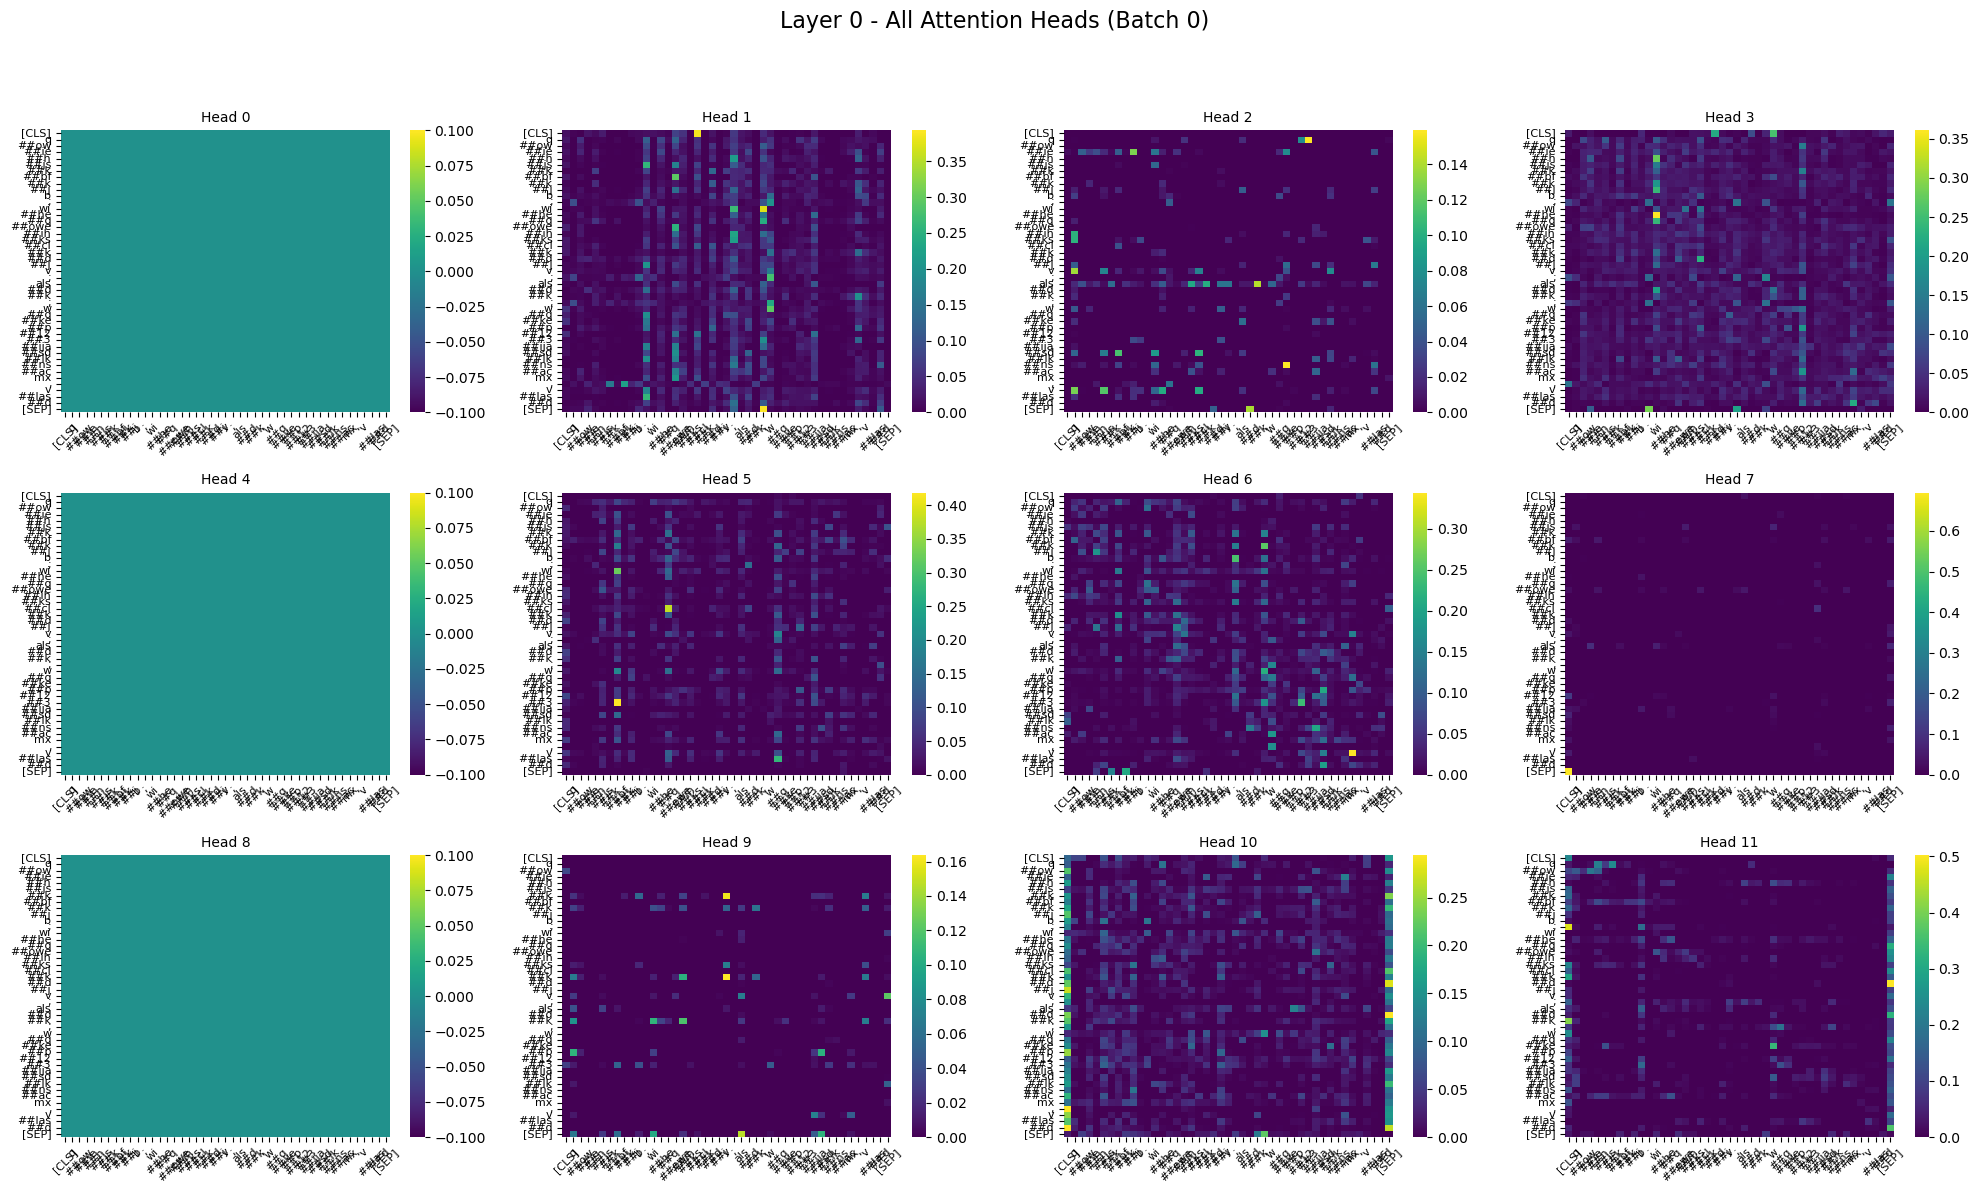

KeyboardInterrupt: 

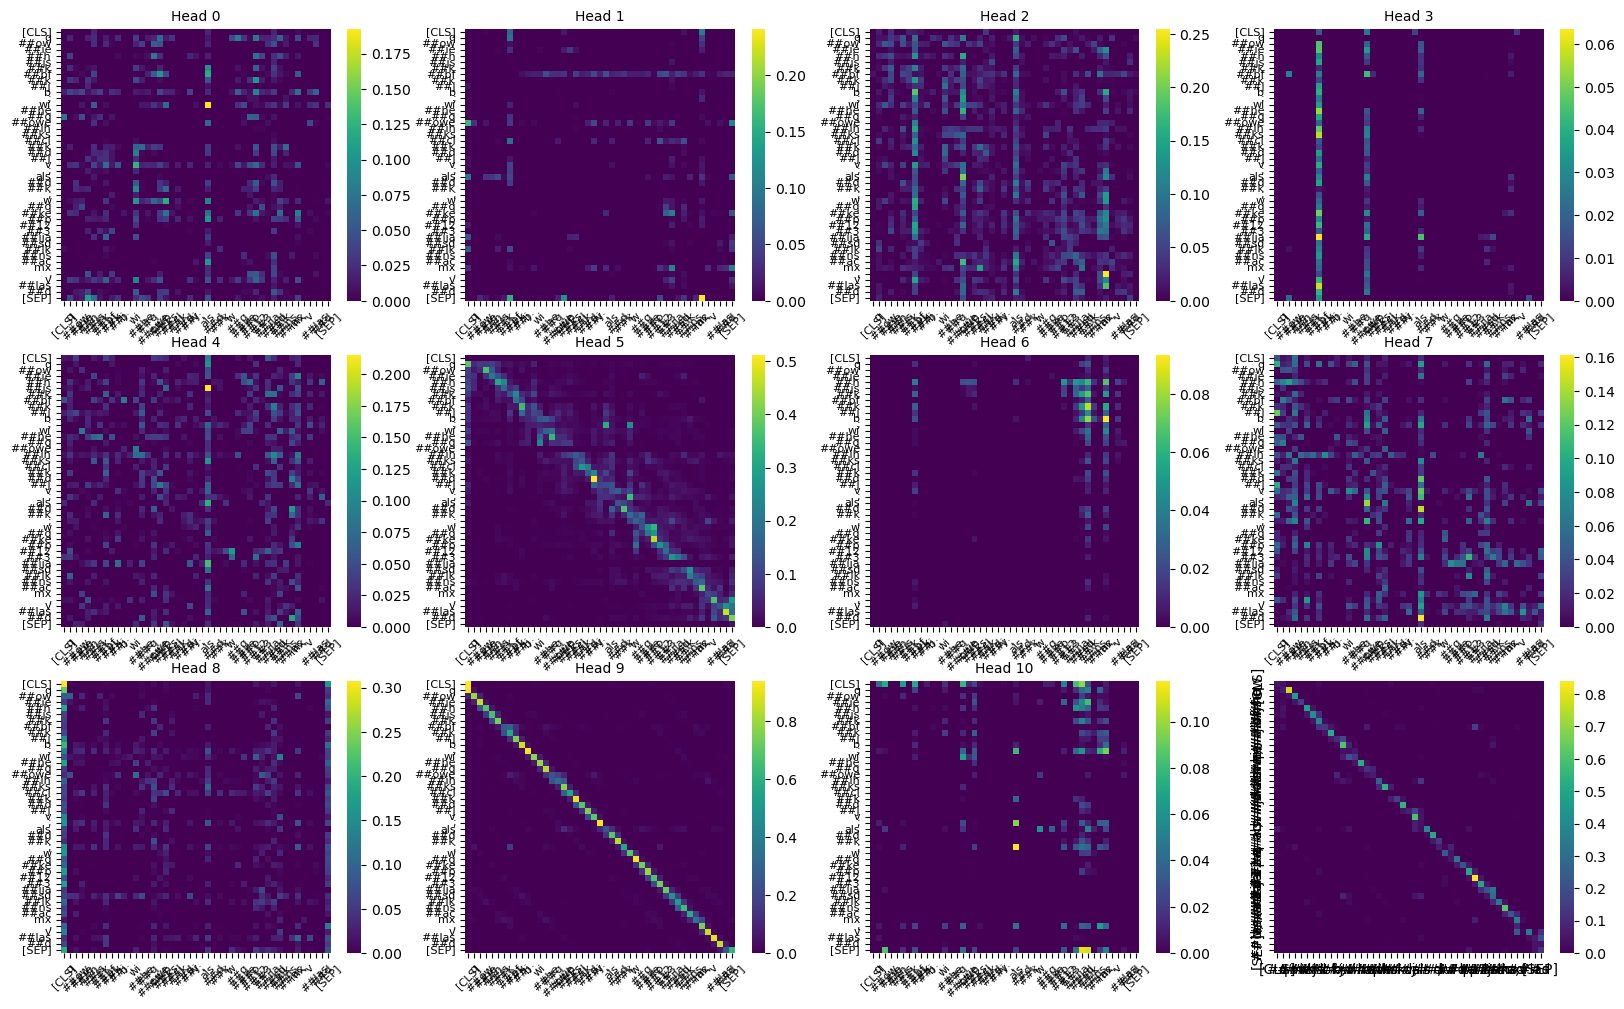

In [11]:

for layer_you_want_to_see in range(12):
    if 0 <= layer_you_want_to_see < len(attention_data_for_plotting):
        selected_layer_data = attention_data_for_plotting[layer_you_want_to_see]

        if selected_layer_data is not None:
            plot_all_heads_for_layer(
                layer_attention_probs=selected_layer_data,
                tokens=tokens,
                layer_number_for_title=layer_you_want_to_see,
                batch_idx_to_plot=0,
                num_cols=4,  # Adjust number of columns for the head grid
                # figure_figsize_scale=(5,4), # You can adjust this for finer control
                # save_path=f"my_model_layer_{layer_you_want_to_see}_all_heads.png"
            )
        else:
            print(f"No attention data captured for layer {layer_you_want_to_see}.")
    else:
        print(f"Layer index {layer_you_want_to_see} is out of range.")